In [1]:
%pip install -q datasets transformers

     |████████████████████████████████| 451 kB 6.9 MB/s 
     |████████████████████████████████| 5.8 MB 59.2 MB/s 
     |████████████████████████████████| 132 kB 74.8 MB/s 
     |████████████████████████████████| 212 kB 56.1 MB/s 
     |████████████████████████████████| 182 kB 69.2 MB/s 
     |████████████████████████████████| 127 kB 28.2 MB/s 
     |████████████████████████████████| 7.6 MB 29.6 MB/s 


In [2]:
from datasets import load_dataset 

dataset = load_dataset("fashion_mnist")

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-3-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
example=dataset["train"][0]

In [6]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [7]:
example['image']

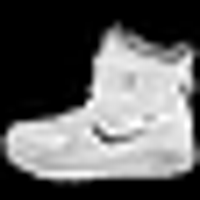

In [8]:
example['image'].resize((200, 200))

In [9]:
example['label']

9

In [10]:
dataset["train"].features["label"]

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'Pullover'

In [12]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("google/mobilenet_v2_1.0_224")

model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

In [13]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_transforms = Compose([RandomResizedCrop((224,224)), ToTensor(), normalize])

In [14]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [15]:
dataset = dataset.with_transform(transforms)

In [16]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [17]:
dataset['train'][0]

{'label': 9,
 'pixel_values': tensor([[[-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],
          [-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],
          [-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],
          ...,
          [ 0.3412,  0.3412,  0.3412,  ...,  0.5216,  0.5216,  0.5216],
          [ 0.3412,  0.3412,  0.3412,  ...,  0.5216,  0.5216,  0.5216],
          [ 0.3412,  0.3412,  0.3412,  ...,  0.5216,  0.5216,  0.5216]],
 
         [[-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],
          [-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],
          [-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],
          ...,
          [ 0.3412,  0.3412,  0.3412,  ...,  0.5216,  0.5216,  0.5216],
          [ 0.3412,  0.3412,  0.3412,  ...,  0.5216,  0.5216,  0.5216],
          [ 0.3412,  0.3412,  0.3412,  ...,  0.5216,  0.5216,  0.5216]],
 
         [[-1.0000, -1.0000, -1.0000,  ...,  0.6706,  0.6706,  0.6706],

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [19]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/mobilenet_v2_1.0_224",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True,
)

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([10, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model_checkpoint='google/mobilenet_v2_1.0_224'
batch_size = 32 

In [21]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     per_device_train_batch_size=16,
#     evaluation_strategy="steps",
#     num_train_epochs=4,
#     fp16=True,
#     save_steps=100,
#     eval_steps=100,
#     logging_steps=10,
#     learning_rate=2e-4,
#     save_total_limit=2,
#     remove_unused_columns=False,
# )

training_args = TrainingArguments(
    output_dir="./results",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)



In [22]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)




In [24]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 60000
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 7020
  Number of trainable parameters = 2236682


Epoch,Training Loss,Validation Loss,Accuracy
0,1.118900,1.021756,0.650000
1,0.732500,0.677181,0.760600
2,0.643700,0.596334,0.792000
3,0.553800,0.527253,0.806100
4,0.531300,0.485284,0.828100
5,0.511100,0.485702,0.826200
6,0.473800,0.482799,0.825800
7,0.494100,0.465944,0.830400
8,0.470600,0.443380,0.838500
9,0.438800,0.448178,0.837700


***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-468
Configuration saved in ./results/checkpoint-468/config.json
Model weights saved in ./results/checkpoint-468/pytorch_model.bin
Image processor saved in ./results/checkpoint-468/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-936
Configuration saved in ./results/checkpoint-936/config.json
Model weights saved in ./results/checkpoint-936/pytorch_model.bin
Image processor saved in ./results/checkpoint-936/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1404
Configuration saved in ./results/checkpoint-1404/config.json
Model weights saved in ./results/checkpoint-1404/pytorch_model.bin
Image processor saved in ./results/checkpoint-1404/preprocessor_config.json
***** Running Evaluat

***** train metrics *****
  epoch                    =         15.0
  total_flos               = 1693047320GF
  train_loss               =       0.6196
  train_runtime            =   1:39:35.79
  train_samples_per_second =      150.607
  train_steps_per_second   =        1.175


In [25]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 32


***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.8535
  eval_loss               =     0.4104
  eval_runtime            = 0:00:36.57
  eval_samples_per_second =    273.386
  eval_steps_per_second   =      8.557


In [26]:
trainer.save_model("model.json")

Saving model checkpoint to model.json
Configuration saved in model.json/config.json
Model weights saved in model.json/pytorch_model.bin
Image processor saved in model.json/preprocessor_config.json


In [27]:
from google.colab import files
files.download('/content')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
